In [30]:
import snap
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd  # To read data
from math import log

import csv
import webbrowser

import networkx as nx

In [2]:
edges=pd.read_csv('title-data/snap-redditHyperlinks-title.csv', names = ["source","destination"])
labels=pd.read_csv('title-data/snap-subreddit-ids-title.csv', names = ["name","id"])

In [3]:
edges.head()

,source,destination
0,0,1
1,2,3
2,4,3
3,5,6
4,5,7


In [4]:
labels.head()

,name,id
0,rddtgaming,0
1,rddtrust,1
2,xboxone,2
3,battlefield_4,3
4,ps4,4


# Code from HW1.1

In [19]:
def makeGraph(edges, N):
    """
    :param - N: number of nodes

    return type: snap.PUNGraph
    """
    ############################################################################
    # TODO: Your code here!
    G1 = snap.TUNGraph.New()
    for i in range(N):
        G1.AddNode(i)
    for index, row in edges.iterrows():
        a = int(row['source'])
        b = int(row['destination'])
#         print(a)
#         print(b)
        G1.AddEdge(a, b)
    Graph = snap.ConvertGraph(snap.PUNGraph, G1)
    ############################################################################
    return Graph


In [10]:
G = makeGraph(edges, len(edges))

In [23]:
def getDataPointsToPlot(Graph):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph

    return values:
    X: list of degrees
    Y: list of frequencies: Y[i] = fraction of nodes with degree X[i]
    """
    ############################################################################
    # TODO: Your code here!
    cntDeg = snap.TIntPrV()
    snap.GetDegCnt(Graph, cntDeg)
    X = []
    Y = []
    for i in sorted(cntDeg):
        if i.GetVal1() != 0:
            X.append(i.GetVal1())
            Y.append(i.GetVal2())
    ############################################################################
    return X, Y

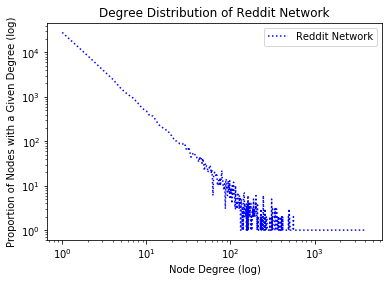

In [26]:
x_rNet, y_rNet = getDataPointsToPlot(G)
plt.loglog(x_rNet, y_rNet, linestyle = 'dotted', color = 'b', label = 'Reddit Network')

plt.xlabel('Node Degree (log)')
plt.ylabel('Proportion of Nodes with a Given Degree (log)')
plt.title('Degree Distribution of Reddit Network')
plt.legend()
plt.show()

In [29]:
def calcClusteringCoefficientSingleNode(Node, Graph):
    """
    :param - Node: node from snap.PUNGraph object. Graph.Nodes() will give an
                   iterable of nodes in a graph
    :param - Graph: snap.PUNGraph object representing an undirected graph

    return type: float
    returns: local clustering coeffient of Node
    """
    ############################################################################
    # TODO: Your code here!
    nodeDeg = Node.GetDeg()
    nodeId = Node.GetId()
    count = 0
    for i in Node.GetOutEdges():
        for j in Node.GetOutEdges():
            if Graph.IsEdge(i,j):
                count += 1
    if nodeDeg >=2:
        C = float(count)/((nodeDeg)*(nodeDeg-1))
    else: 
        C = 0

    ############################################################################
    return C

def calcClusteringCoefficient(Graph):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph

    return type: float
    returns: clustering coeffient of Graph
    """
    ############################################################################
    # TODO: Your code here! If you filled out calcClusteringCoefficientSingleNode,
    #       you'll probably want to call it in a loop here
    sumCoeff=0
    V = Graph.GetNodes()
    for i in Graph.Nodes():
        sumCoeff+=calcClusteringCoefficientSingleNode(i,Graph)
    C = 1/float(V)*sumCoeff

    ############################################################################
    return C

def Q1_2(G):
    """
    Code for Q1.2
    """
    C_Reddit = calcClusteringCoefficient(G)

    print('Clustering Coefficient for Reddit Network: %f' % C_Reddit)

# Execute code for Q1.2
Q1_2(G)

Clustering Coefficient for Reddit Network: 0.017431


# Code from HW1.2

In [31]:
def getNeighbors(i):
    NIdVIn = snap.TIntV()
    NIdVIn.Add(i.GetId())
    for j in i.GetOutEdges():
        NIdVIn.Add(j) 
    return NIdVIn

def cosSim(dictionary, idx):
    a = dictionary[idx]
    print("Feature Vector",a)
    simDict = {}
    for i in dictionary.keys():
        if i != 9:
            b = dictionary[i] 
            dot = np.dot(a, b)
            norma = np.linalg.norm(a)
            normb = np.linalg.norm(b)
            if norma != 0 and normb != 0:
                cos = dot / (norma * normb)
            else:
                cos = 0
            simDict.update({i: cos})
            
    return list(sorted(simDict.items(), key=lambda item: item[1], reverse = True))
    
dictionary ={}
for i in G.Nodes():
    nodeDeg = i.GetDeg() 
    G2 = snap.GetSubGraph(G, getNeighbors(i))
    numEdgesInEgoNet = G2.GetEdges()
    numberEdgesSurround = 0
    for j in G.Nodes():
        for k in G2.Nodes():
            if j!=k and G.IsEdge(j.GetId(),k.GetId()) and not G2.IsEdge(j.GetId(),k.GetId()):
                numberEdgesSurround += 1 
    dictionary.update({i.GetId():[nodeDeg,numEdgesInEgoNet, numberEdgesSurround]}) 
#ID of boners = 41491 - banned subreddit
print(cosSim(dictionary, 41491)[0:5])

KeyboardInterrupt: 

In [ ]:
#once dictionary is built, no need to rerun
#can just change the index of the below code to find cosSim of new node
#print(cosSim(dictionary, 41491)[0:5])

In [ ]:
#Question 2.2
orig = dictionary.copy()

def recurse(G, orig, K):
    K+=1
    newDict = {}
    for i in G.Nodes():
        nodeVec = orig[i.GetId()].copy()
        sumOfNbrs = [0]*len(nodeVec)
        count = 0
        for j in i.GetOutEdges():
            sumOfNbrs = np.add(sumOfNbrs, orig[j])
            count += 1
        if count != 0:
            mean = [x / float(count) for x in sumOfNbrs]
        else:
            mean = [0]*len(nodeVec)
        nodeVec.extend(mean)
        nodeVec.extend(sumOfNbrs)
        newDict.update({i.GetId(): nodeVec})
    if K == 2:
        return newDict
    else:
        return recurse(G,newDict,K)
expanded = recurse(G, orig, 0)
x = cosSim(expanded, 41491)
print(x[0:5])

In [ ]:
#can just change the index of the below code to find cosSim of new node
#print(cosSim(expanded, 41491)[0:5])

In [ ]:
#Question 2.3a
y = { x[i][0] : x[i][1] for i in range(0, len(x))}
plt.hist(y.values(), bins=20)
plt.xticks(np.arange(0,1,0.1))
plt.ylabel('Count');
plt.xlabel('Cosine Similarity');

In [ ]:
#Question 2.3b 
#For these groups / roles in the cosine similarity histogram, 
#take one node u from each group to examine the feature vector, 
#and draw the subgraph of the node based on its feature vector. 
#You can draw the subgraph by hand, or you can use libraries such as networkx or graphviz.
#Question 2.3b

# for three in G.GetNI(3).GetOutEdges():
#     print("3",three)
# for four in G.GetNI(4).GetOutEdges():
#     print("4",four)
# for five in G.GetNI(5).GetOutEdges():
#     print("5",five)
# for six in G.GetNI(6).GetOutEdges():
#     print(6,six)
    
# print("688: Cosine Similarity = 0")
# for a in G.GetNI(688).GetOutEdges():
#     print(a)
# print("Feature Vector:", dictionary[688])
# g = nx.Graph()
# g.add_node(688)
# plt.figure()
# nx.draw_networkx(g)
# plt.show()

# for b in G.GetNI(1523).GetOutEdges():
#     print(b)
# print("1523: Cosine Similarity = 0.60422")
# print("Feature Vector:", dictionary[1523])
# k = nx.Graph()
# k.add_node(1523)
# k.add_node(1522)
# k.add_edge(1522,1523)
# plt.figure()
# nx.draw_networkx(k)
# plt.show()

# print("2: Cosine Similarity = 0.90975")
# print("Feature Vector:", dictionary[2])
# k = nx.Graph()
# for c in G.GetNI(2).GetOutEdges():
#     k.add_node(c)
#     k.add_edge(2,c)
# k.add_edge(3,4)
# k.add_edge(3,5)
# k.add_edge(3,6)
# k.add_edge(4,6)
# k.add_edge(4,5)
# k.add_edge(5,6)
# plt.figure()
# nx.draw_networkx(k)
# plt.show()

# Code from HW0

In [11]:
total = G.GetNodes()
print("The number of nodes in the network: %d" % total)
print("The number of nodes with a self-edge : %d" % snap.CntSelfEdges(G))
print("The number of directed edges in the network: %d" % snap.CntUniqDirEdges(G))
print("The number of undirected edges in the network : %d" % snap.CntUniqUndirEdges(G))

print("The number of reciprocated edges in the network: %d" % snap.CntUniqBiDirEdges(G))
print("The number of nodes of zero out-degree : %d" % snap.CntOutDegNodes(G,0))
print("The number of nodes of zero in-degree: %d" % snap.CntInDegNodes(G,0))

The number of nodes in the network: 571927
The number of nodes with a self-edge : 0
The number of directed edges in the network: 440302
The number of undirected edges in the network : 220151
The number of reciprocated edges in the network: 220151
The number of nodes of zero out-degree : 517852
The number of nodes of zero in-degree: 517852


In [12]:
#Check
DegToCntV = snap.TIntPrV()
snap.GetOutDegCnt(G, DegToCntV)
countOut = 0
for item in DegToCntV:
    if item.GetVal1() > 10:
        countOut += item.GetVal2()
print("The number of nodes with more than 10 outgoing edges : %d" % countOut)
DegToCntV = snap.TIntPrV()
snap.GetInDegCnt(G, DegToCntV)
countIn = 0
for item in DegToCntV:
    if item.GetVal1() < 10:
        countIn += item.GetVal2()
print("The number of nodes with fewer than 10 incoming edges : %d" % countIn)

The number of nodes with more than 10 outgoing edges : 5495
The number of nodes with fewer than 10 incoming edges : 565950


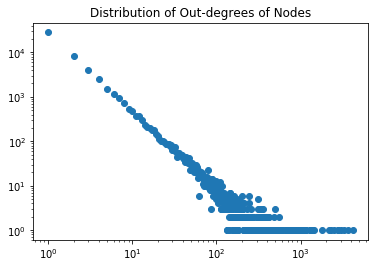

In [14]:
# 2 Further Analyzing the network 
#part1
cntDeg = snap.TIntPrV()
snap.GetOutDegCnt(G, cntDeg)
fig2 = plt.figure()
x = []
y = []
for i in sorted(cntDeg):
    if i.GetVal1() != 0:
        x.append(i.GetVal1())
        y.append(i.GetVal2())
fig2 = plt.plot(x, y, 'o')
plt.xscale('log')
plt.yscale('log')
plt.title("Distribution of Out-degrees of Nodes")
plt.savefig("degDistr.png")

polyfit coefficients : [-1.30930011  3.53285394]


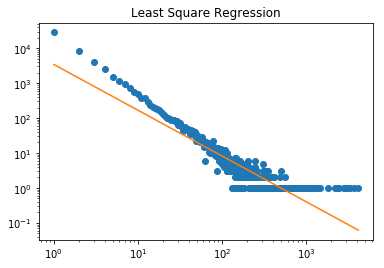

In [32]:
#part2
fig2 = plt.figure()
xLog = []
yLog = []
for i in sorted(cntDeg):
    if i.GetVal1() != 0:
        xLog.append(log(i.GetVal1(),10))
        yLog.append(log(i.GetVal2(),10))
pfit = np.polyfit(xLog, yLog, 1)
print("polyfit coefficients :", pfit)
line = np.poly1d(pfit)
fig2 = plt.plot(x,y,'o')

line = pow(10, pfit[1])*pow(x,pfit[0])
plt.plot(x, line)
plt.xscale('log')
plt.yscale('log')
plt.title("Least Square Regression")
plt.savefig("least-squareregression.png")

In [15]:
#3 Finding Central Nodes
Components = snap.TCnComV()
snap.GetWccs(G, Components)
print("The number of weakly connected components in the network: %d" % Components.Len())

largestComponent = snap.GetMxWcc(G)
edges =largestComponent.GetEdges()
nodes =largestComponent.GetNodes()
print("In the largest weakly connected component, the number of edges: %d, and the number of nodes: %d" % (edges, nodes))

pageR = snap.TIntFltH()
snap.GetPageRank(G, pageR)
ordering = {}
for item in pageR:
    ordering.update({item: pageR[item]})
sorted_hash = sorted(ordering.items(), key=lambda x: x[1], reverse = True)
print("IDs of the top 3 most central nodes in the network by PagePank scores: %d, %d, %d" % (sorted_hash[0][0],sorted_hash[1][0],sorted_hash[2][0]))

hubs = snap.TIntFltH()
auth = snap.TIntFltH()
snap.GetHits(G, hubs, auth)
orderingHub = {}
for item in hubs:
    orderingHub.update({item: hubs[item]})
orderingAuth = {}
for item in auth:
    orderingAuth.update({item: auth[item]})
sorted_hubs = sorted(orderingHub.items(), key=lambda x: x[1], reverse = True)
sorted_auth = sorted(orderingAuth.items(), key=lambda x: x[1], reverse = True)
print("By HITS scores, IDs of the top 3 hubs: %d, %d, %d and top 3 authorities in the network: %d, %d, %d" %
    (sorted_hubs[0][0],sorted_hubs[1][0],sorted_hubs[2][0], 
    sorted_auth[0][0],sorted_auth[1][0],sorted_auth[2][0]))

The number of weakly connected components in the network: 518610
In the largest weakly connected component, the number of edges: 219296, and the number of nodes: 52468
IDs of the top 3 most central nodes in the network by PagePank scores: 43, 85, 16
By HITS scores, IDs of the top 3 hubs: 16, 28, 43 and top 3 authorities in the network: 16, 28, 43


In [33]:
#HOW TO ACTUALLY VISUALIZE THE NETWORK???
actual = snap.TIntStrH()
for NI in G.Nodes():
    actual[NI.GetId()]= str(NI.GetId())
snap.DrawGViz(G, snap.gvlDot, "output.png", "", actual)

# From SNAP Website
https://snap.stanford.edu/snap-1.8/doc.html

In [42]:
# # get distribution of connected components (component size, count)
# CntV = snap.TIntPrV()
# # TVec(snap.TIntPr(TInt,TInt)) CntV; # vector of pairs of integers (size, count)
# print("distribution of connected components: ", snap.GetWccSzCnt(G, CntV));

In [43]:
# # get degree distribution pairs (degree, count)
# print("degree distribution pairs: ",snap.GetOutDegCnt(G));

In [44]:
# # get first eigenvector of graph adjacency matrix
# TFltV EigV; # vector of floats
# print("first eigenvector: ", snap.GetEigVec(G, EigV));

SyntaxError: invalid syntax (<ipython-input-44-de3b6473a72b>, line 2)

In [45]:
# # get diameter of G
# print("diameter of G: ", snap.GetBfsFullDiam(G));


TypeError: GetBfsFullDiam_PUNGraph() missing 1 required positional argument: 'NTestNodes'

In [46]:
# count the number of triads in G, get the clustering coefficient of G
print("the number of triads: ", snap.GetTriads(G));
print("Clustering Coefficient: ", snap.GetClustCf(G));

the number of triads:  1329278
Clustering Coefficient:  0.01743094218900993
